<h1 style="background-color:DodgerBlue;"> Anamoly detection ||  Time series ➤ Facebook Prophet </h1>

## 🚨  **Scenario: Time Series Anomaly Detection in API Request Volume **
- Goal: Detecting Anomalous Spikes in Hourly API Traffic

**Description**:  
Imagine a backend API service used by a mobile application. Normally, the number of hourly API requests follows a predictable pattern. Sudden spikes or drops in request volume can indicate issues like:
- Bot traffic 🤖  
- Server misconfiguration ⚠️  
- App version bugs 🐞  

We'll use **Facebook Prophet** to:
- Model normal hourly API traffic  
- Predict expected values  
- Flag significant deviations as anomalies

### 📦 **1. Prepare the Data**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Simulate hourly API requests with seasonality and noise
np.random.seed(42)
date_range = pd.date_range(start="2023-01-01", periods=240, freq='H')
y = 100 + 20 * np.sin(np.linspace(0, 3 * np.pi, 240)) + np.random.normal(0, 5, 240)

# Inject synthetic anomalies
y[50] = 200  # Sudden spike
y[120] = 30  # Drop
y[190] = 220  # Big jump

df = pd.DataFrame({'ds': date_range, 'y': y})
df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_11472\4262000116.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2023-01-01", periods=240, freq='H')


,ds,y
0,2023-01-01 00:00:00,102.483571
1,2023-01-01 01:00:00,100.097158
2,2023-01-01 02:00:00,104.814177
3,2023-01-01 03:00:00,109.975687
4,2023-01-01 04:00:00,101.970905


In [ ]:
### 🔮 **2. Train Facebook Prophet Model**

In [3]:
from prophet import Prophet

model = Prophet()
model.fit(df)

16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing


### 📅 **3. Forecast Using Prophet**

In [4]:
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

# Merge predictions
df['yhat'] = forecast['yhat']
df.head()

,ds,y,yhat
0,2023-01-01 00:00:00,102.483571,109.373651
1,2023-01-01 01:00:00,100.097158,108.502465
2,2023-01-01 02:00:00,104.814177,109.122612
3,2023-01-01 03:00:00,109.975687,110.628822
4,2023-01-01 04:00:00,101.970905,111.497670


### 🚨 **4. Detect Anomalies (Residual Method)**

In [5]:
df['residual'] = df['y'] - df['yhat']
residual_std = np.std(df['residual'])
threshold = 2 * residual_std

df['anomaly'] = np.where(np.abs(df['residual']) > threshold, 1, 0)
df.head()

,ds,y,yhat,residual,anomaly
0,2023-01-01 00:00:00,102.483571,109.373651,-6.890080,0
1,2023-01-01 01:00:00,100.097158,108.502465,-8.405306,0
2,2023-01-01 02:00:00,104.814177,109.122612,-4.308435,0
3,2023-01-01 03:00:00,109.975687,110.628822,-0.653135,0
4,2023-01-01 04:00:00,101.970905,111.497670,-9.526765,0


### 📈 **5. Visualize Forecast & Anomalies**

C:\Users\USER\AppData\Local\Temp\ipykernel_11472\2811827104.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


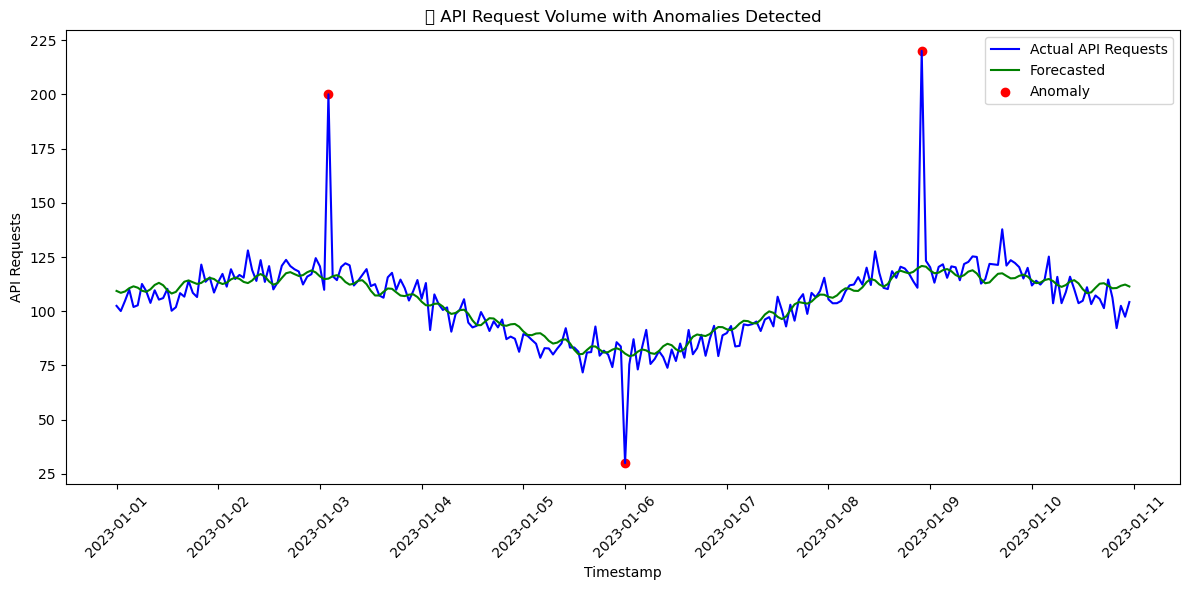

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual API Requests', color='blue')
plt.plot(df['ds'], df['yhat'], label='Forecasted', color='green')
plt.scatter(df['ds'][df['anomaly'] == 1], df['y'][df['anomaly'] == 1], color='red', label='Anomaly')
plt.title('📊 API Request Volume with Anomalies Detected')
plt.xlabel('Timestamp')
plt.ylabel('API Requests')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📤 **6. Export Anomalies**

In [7]:
anomalies = df[df['anomaly'] == 1]
anomalies.to_csv("api_anomalies.csv", index=False)
print(anomalies[['ds', 'y', 'yhat', 'residual']])

                     ds      y        yhat   residual
50  2023-01-03 02:00:00  200.0  115.044796  84.955204
120 2023-01-06 00:00:00   30.0   80.477986 -50.477986
190 2023-01-08 22:00:00  220.0  120.883931  99.116069


### 🧪 **7. Test a New API Request Sample**

In [8]:
# Sample test for a new point (simulate 1-hour data)
new_request_volume = 250  # Unusually high
new_time = pd.DataFrame({'ds': [pd.Timestamp("2023-01-11 01:00:00")]})
future_extended = pd.concat([df[['ds']], new_time], ignore_index=True)
forecast_ext = model.predict(future_extended)

# Get predicted value for that timestamp
predicted = forecast_ext[forecast_ext['ds'] == new_time['ds'][0]]['yhat'].values[0]
residual = new_request_volume - predicted

print(f"\nTest Sample: {new_time['ds'][0]}")
print(f"Actual Requests: {new_request_volume}, Predicted: {predicted:.2f}, Residual: {residual:.2f}")

if abs(residual) > threshold:
    print("❗ This is an ANOMALY.")
else:
    print("✅ This is NORMAL behavior.")


Test Sample: 2023-01-11 01:00:00
Actual Requests: 250, Predicted: 108.40, Residual: 141.60
❗ This is an ANOMALY.
